<a href="https://colab.research.google.com/github/TongQM/SONAR_VLM/blob/main/sonar_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install SONAR embeddings and requirements

In [ ]:
!pip show torch
# !pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
# !pip install sonar-space

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fairseq2n, fastai, peft, sentence-transformers, sonar-space, timm, torchaudio, torchvision


# Mount Google drive and set work directory

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/')
# !ls annotations/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Download Data

In [ ]:
!mkdir images
!cd images
# # Download the images from the COCO dataset
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip
# wget http://images.cocodataset.org/zips/unlabeled2017.zip

# Unzip the images
!unzip train2017.zip
!unzip val2017.zip
!unzip test2017.zip
# unzip unlabeled2017.zip

# # Remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm unlabeled2017.zip

# # Download the annotations from the COCO dataset
!cd ../
!mkdir annotations
!cd annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip
# wget http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip

# # Unzip the annotations
!unzip annotations_trainval2017.zip
# unzip stuff_annotations_trainval2017.zip
!unzip image_info_test2017.zip
# unzip image_info_unlabeled2017.zip

# # Remove the zip files
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip
# !rm image_info_unlabeled2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: test2017/000000318429.jpg  
 extracting: test2017/000000381787.jpg  
 extracting: test2017/000000287482.jpg  
 extracting: test2017/000000459614.jpg  
 extracting: test2017/000000010879.jpg  
 extracting: test2017/000000044270.jpg  
 extracting: test2017/000000233321.jpg  
 extracting: test2017/000000515253.jpg  
 extracting: test2017/000000562454.jpg  
 extracting: test2017/000000219662.jpg  
 extracting: test2017/000000270965.jpg  
 extracting: test2017/000000497647.jpg  
 extracting: test2017/000000273880.jpg  
 extracting: test2017/000000413721.jpg  
 extracting: test2017/000000546526.jpg  
 extracting: test2017/000000189624.jpg  
 extracting: test2017/000000432585.jpg  
 extracting: test2017/000000464855.jpg  
 extracting: test2017/000000489326.jpg  
 extracting: test2017/000000202481.jpg  
 extracting: test2017/000000572501.jpg  
 extracting: test2017/000000188680.jpg  
 extracting: test2017/000000400877.jpg  
 extra

### Import necessary packages

In [ ]:
import json
import torch
import torch.nn as nn
import os
import gc
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn import CosineEmbeddingLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet50, resnet152, ResNet152_Weights, ResNet50_Weights
from torchsummary import summary

from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'mps' if torch.backends.mps.is_available() else device
print(f"Using device: {device}")

Using device: cuda


## Load text2embedding model

In [ ]:
t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device(device),
                                           dtype=torch.float16)
sentences = ['I want to get an intern offer pls', 'Why I have so bad luck']
embeddings = t2vec_model.predict(sentences, source_lang="eng_Latn")


vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=torch.device(device),
                                              dtype=torch.float32)
reconstructed = vec2text_model.predict(embeddings, target_lang="eng_Latn", max_seq_len=512)
print("Original sentences:")
for sentence in sentences:
    print(sentence)
print("\nReconstructed sentences:")
for sentence in reconstructed:
    print(sentence)

Original sentences:
I want to get an intern offer pls
Why I have so bad luck

Reconstructed sentences:
I want to get an internship offer pls
Why I have such bad luck


## Load train and validation data

### Precompute the embeddings of captions for each image

In [ ]:
import json
import torch
from collections import defaultdict
from tqdm import tqdm

def precompute_caption_embeddings(
    coco_json: str,
    text_encoder,
    output_path: str,
    numcaps: int = 5,
    batch_size: int = 512,
    device: str = "cpu",
):
    """
    Reads the COCO captions JSON, groups & truncates to `numcaps` per image,
    encodes *all* captions through your text_encoder, then splits them back
    into a dict mapping `"<image_id>.jpg"` → Tensor of shape (numcaps, D),
    and torch.saves that dict to `output_path`.
    """
    # 1) load & group captions
    with open(coco_json) as f:
        coco = json.load(f)
    caps = defaultdict(list)
    for ann in coco["annotations"]:
        key = f"{ann['image_id']:012d}.jpg"
        caps[key].append(ann["caption"])
    # truncate
    for k in caps:
        caps[k] = sorted(caps[k])[:numcaps]

    # 2) flatten all captions
    items   = list(caps.items())                # [(img_name, [cap1,…]), …]
    all_caps = [cap for _, clist in items for cap in clist]

    # 3) encode in batches for memory‐efficiency
    text_encoder.to(device).eval()
    all_embs = []
    with torch.no_grad():
        for i in tqdm(range(0, len(all_caps), batch_size)):
            batch = all_caps[i : i + batch_size]
            emb = text_encoder.predict(batch, source_lang="eng_Latn")
            emb = torch.as_tensor(emb) if not isinstance(emb, torch.Tensor) else emb
            all_embs.append(emb.cpu())
    all_embs = torch.cat(all_embs, dim=0)       # (sum(counts), D)

    # 4) split back per image
    embedding_map = {}
    idx = 0
    D   = all_embs.size(1)
    for img_name, clist in items:
        m = len(clist)
        embedding_map[img_name] = all_embs[idx : idx + m]  # (m, D)
        idx += m

    # 5) save to disk
    torch.save(embedding_map, output_path)

In [ ]:
precompute_caption_embeddings(
    coco_json     = "./data/captions_val2017.json",
    text_encoder  = t2vec_model,
    output_path   = "/content/coco2017_valcaption_embs.pt",
    numcaps       = 5,
    batch_size    = 1024,
    device        = device,
)

100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


In [ ]:
# Load valcaption_embs
val_caption_embs = torch.load("/content/coco2017_valcaption_embs.pt")
sample_embs = val_caption_embs['000000519491.jpg']

# The original captions
with open("./data/captions_val2017.json") as f:
    coco = json.load(f)
    caps = defaultdict(list)
    for ann in coco["annotations"]:
        key = f"{ann['image_id']:012d}.jpg"
        caps[key].append(ann["caption"])
print(f"The original captions are {caps['000000519491.jpg']}")
print(f"The deciphered captions are {vec2text_model.predict(sample_embs, target_lang='eng_Latn', max_seq_len=512)}.")

The original captions are ['A tall clock tower with a statue on top.', 'There is a clock in the top of a tall tower', 'A large clock tower with a gargoyle atop sits in front of a clear blue sky.', 'A large clock tower with a statue on the top.', 'Clock tower with a bronze statue on top on a sunny day. ']
The deciphered captions are ['A large clock tower with a gargoyle on top sits in front of a clear blue sky.', 'A large clock tower with a statue on the top.', 'A tall clock tower with a statue on top.', 'Clock tower with a bronze statue on top in a sunny day.', 'There is a clock in the top of a tall tower'].


In [ ]:
# Download coco2017_valcaption_embs.pt
from google.colab import files
files.download('/content/coco2017_valcaption_embs.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
precompute_caption_embeddings(
    coco_json     = "./data/captions_train2017.json",
    text_encoder  = t2vec_model,
    output_path   = "/content/coco2017_traincaption_embs.pt",
    numcaps       = 5,
    batch_size    = 1024,
    device        = device,
)

100%|██████████| 578/578 [29:05<00:00,  3.02s/it]


In [ ]:
files.download('/content/coco2017_traincaption_embs.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Define dataloader with SONAR embeddings as labels

In [ ]:
class COCOCaptionTextDataset(Dataset):
    """
    Returns (image_tensor, list_of_captions) for each idx.
    """
    def __init__(self, img_dir, coco_json, embedding_map_path, training=False, subset=1.0):
        self.img_dir = Path(img_dir)

        if training:
            self.transform = T.Compose([
                T.Resize((224,224)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                T.RandomRotation(10),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3),
            ])
        else:
            self.transform = T.Compose([
                T.Resize((224,224)),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3),
            ])

        self.embedding_map = torch.load(embedding_map_path)

        with open(coco_json) as f:
            coco = json.load(f)

        ids = set(self.embedding_map.keys())
        self.ids = [f"{ann['image_id']:012d}.jpg" for ann in coco["annotations"] if f"{ann['image_id']:012d}.jpg" in ids]
        self.ids = sorted(set(self.ids))

        # If subset < 1.0, take the first subset proportion sample of the dataset
        if subset < 1.0:
            total = len(self.ids)
            k = max(1, int(total * subset))
            self.ids = self.ids[:k]

        self.length = len(self.ids)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_name = self.ids[idx]
        img = Image.open(self.img_dir / img_name).convert("RGB")
        img = self.transform(img)
        caps_emb = self.embedding_map[img_name]  # Tensor of shape (m, D)
        return img, caps_emb

train_dataset = COCOCaptionTextDataset(
    img_dir="./data/images/train2017",
    coco_json="./data/captions_train2017.json",
    embedding_map_path="/content/gdrive/MyDrive/sonar/maps/coco2017_traincaption_embs.pt",
    training=True,
    subset=1,  # 0.1 = 10% of the dataset
)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=True
)

val_dataset = COCOCaptionTextDataset(
    img_dir="./data/images/val2017",
    coco_json="./data/captions_val2017.json",
    embedding_map_path="/content/gdrive/MyDrive/sonar/maps/coco2017_valcaption_embs.pt",
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=True
)

In [ ]:
print(f"There are {len(train_dataset)} training samples.")
print(f"There are {len(val_dataset)} validation samples.")

There are 118287 training samples.
There are 5000 validation samples.


In [ ]:
gc.collect()

67

## Define the model

### Define multi-positive InfoNCE loss

In [ ]:
def multi_pos_infonce_loss(img_embs, cap_embs, temperature):
    """
    img_embs: (B, D)  after F.normalize
    cap_embs: (B, m, D) after F.normalize
    """
    B, m, D = cap_embs.shape
    # flatten captions: (B*m, D)
    flat_caps = cap_embs.view(B*m, D)
    # similarity: (B, B*m)
    logits = img_embs @ flat_caps.t() / temperature

    # numerator: sum over each image's m positives
    # we know that positives for image i are indices [i*m : i*m + m]
    pos_mask = torch.zeros_like(logits, dtype=torch.bool)
    for i in range(B):
        start = i * m
        pos_mask[i, start : start + m] = True

    # exp(logits)
    exp_logits = logits.exp()
    numerator   = exp_logits.masked_select(pos_mask).view(B, m).sum(dim=1)
    denominator = exp_logits.sum(dim=1)
    loss = -torch.log(numerator / denominator).mean()
    return loss

### Resnet50 Encoder

In [ ]:
class ResNet50Embedder(nn.Module):
    """
    ResNet50 backbone producing fixed-size embeddings (e.g., 1024-D).

    Args:
        pretrained (bool): If True, loads ImageNet-pretrained weights.
        embedding_dim (int): Dimensionality of the output embedding.
    """
    def __init__(self, pretrained: bool = True, embedding_dim: int = 1024, weights=ResNet50_Weights.DEFAULT):
        super().__init__()
        # Load ResNet50 backbone
        if pretrained:
            # Use pretrained weights
            weights = ResNet50_Weights.DEFAULT
        base_model = resnet50(weights=weights)
        # Save the feature dimensionality for projection
        in_features = base_model.fc.in_features
        # Replace the final fully connected layer with a new one
        base_model.fc = nn.Linear(in_features, embedding_dim)
        # Initialize the new layer
        nn.init.xavier_uniform_(base_model.fc.weight)
        self.backbone = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: image -> embedding

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Embedding of shape (batch_size, embedding_dim).
        """
        embeddings = self.backbone(x)   # shape: (batch_size, embedding_dim)
        return embeddings

    def load_weights(self, path: str):
        """
        Load weights from a file.

        Args:
            path (str): Path to the weights file.
        """
        state_dict = torch.load(path, weights_only=True)
        self.backbone.load_state_dict(state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Example: produce 1024-D embeddings
encoder = ResNet50Embedder(pretrained=True, embedding_dim=1024).to(device)
# summary(model, (3, 224, 224), device=device.type)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
embed = encoder(dummy_input)
print(f"Output embedding shape: {embed.shape}")


Output embedding shape: torch.Size([10, 1024])


In [ ]:
def train_epoch(model: nn.Module,
          train_loader: DataLoader,
          optimizer: torch.optim.Optimizer,
          scaler: torch.cuda.amp.GradScaler,
          criterion: nn.Module,
          device: str,
          epoch: int = 1,
          num_epochs: int = 10) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    cum_loss, cnt = 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    for images, caption_embs in pbar:
        images, caption_embs = images.to(device), caption_embs.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device, dtype=torch.float16):
            img_embs = encoder(images)  # (B, D)
            img_norm = F.normalize(img_embs, dim=-1)      # (B, D)
            cap_norm = F.normalize(caption_embs, dim=-1)  # (B, m, D)
            loss = criterion(img_norm, cap_norm, temperature=0.1)
            cum_loss += loss.item()
            cnt += 1

        pbar.set_postfix(train_loss=f"{loss.item():.4f}")
        pbar.update()

        # Backward with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    return cum_loss / cnt

In [ ]:
# --- Validation function ---
@torch.no_grad()
def validate(model: nn.Module, loader: DataLoader, device: torch.device, margin: float = 0.0) -> float:
    """
    Runs one epoch of validation, returning the average CosineEmbeddingLoss
    over all (positive + negative) pairs.

    Positives: (image_i, each of its m captions) → target +1
    Negatives: (image_i, each of the next image’s m captions) → target -1
    """
    model.eval()
    loss_fn = CosineEmbeddingLoss(margin=margin, reduction="mean")
    total_loss = 0.0
    n_batches  = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Validation")
        for images, cap_embs in pbar:
            images, cap_embs = images.to(device), cap_embs.to(device)
            B, m, D = cap_embs.shape

            # 1) Compute normalized image and caption embeddings
            img_embs  = model(images)                    # (B, D)
            img_norm  = F.normalize(img_embs,  dim=-1)    # (B, D)
            cap_norm  = F.normalize(cap_embs,    dim=-1)  # (B, m, D)

            # 2) Build positive pairs
            #    (B, D) → (B, 1, D) → (B, m, D) → (B*m, D)
            img_pos   = img_norm.unsqueeze(1).expand(-1,m,-1).reshape(B*m, D)
            cap_pos   = cap_norm.reshape(B*m, D)
            pos_tgt   = torch.ones(B*m, device=device)    # +1

            # 3) Build negative pairs by “rolling” captions by 1 in batch
            cap_neg   = cap_norm.roll(shifts=1, dims=0)   # (B, m, D)
            img_neg   = img_pos                            # same images
            cap_neg   = cap_neg.reshape(B*m, D)
            neg_tgt   = -torch.ones(B*m, device=device)   # -1

            # 4) Concatenate into one big batch
            all_imgs = torch.cat([img_pos, img_neg], dim=0)  # (2*B*m, D)
            all_caps = torch.cat([cap_pos, cap_neg], dim=0)  # (2*B*m, D)
            all_lbls = torch.cat([pos_tgt, neg_tgt], dim=0)  # (2*B*m,)

            # 5) Compute loss
            loss = loss_fn(all_imgs, all_caps, all_lbls)
            total_loss += loss.item()
            n_batches  += 1

            pbar.set_postfix(curr_loss=f"{loss.item():.4f}")
            pbar.update()

    pbar.close()

    return total_loss / n_batches

In [ ]:
def load_model(model: nn.Module, path: str):
    """
    Load weights from a file.
    """
    state_dict = torch.load(path, weights_only=True)
    model.load_state_dict(state_dict)
    print(f"Loaded weights from {path}")
    return model

def save_model(model: nn.Module, path: str):
    """
    Save weights to a file.
    """
    torch.save(model.state_dict(), path)
    print(f"Saved weights to {path}")

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    # print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

In [ ]:
# Hyperparameters
lr = 1e-4
weight_decay = 1e-2
temperature = 0.07
num_epochs = 20

# Setup
# train_criterion = nn.CrossEntropyLoss()
val_criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.amp.GradScaler()

best_val_loss = float("inf")
encoder, _, _, epoch, best_val_loss = load_model(path=f"/content/gdrive/MyDrive/sonar/best_encoder.pth",
                                                 encoder, optimizer= None, scheduler= None, metric="val_loss")

for epoch in range(1, num_epochs + 1):
    # Train
    train_loss = train_epoch(encoder, train_loader, optimizer, scaler, multi_pos_infonce_loss, device, epoch=epoch, num_epochs=num_epochs)
    val_loss = validate(encoder, val_loader, device, margin=0.0)
    scheduler.step(val_loss)
    print(f"Epoch {epoch} Training InfoNCE Loss: {train_loss:.4f}")
    print(f"Epoch {epoch} Validation CosineEmbeddingLoss: {val_loss:.4f}")
    save_model(encoder, optimizer, scheduler, ["val_loss", val_loss], epoch, path=f"/content/gdrive/MyDrive/sonar/last_epoch.pth")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(encoder, optimizer, scheduler, ["val_loss", val_loss], epoch, path=f"/content/gdrive/MyDrive/sonar/best_encoder.pth")

In [ ]:
# Hyperparameters
lr = 1e-4
weight_decay = 1e-2
temperature = 0.07
num_epochs = 20

# Setup
# train_criterion = nn.CrossEntropyLoss()
val_criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.amp.GradScaler()
encoder.train()

best_val_loss = float("inf")
encoder = load_model(encoder, "best_encoder.pth")

for epoch in range(1, num_epochs + 1):
    # Train
    train_loss = train_epoch(encoder, train_loader, optimizer, scaler, multi_pos_infonce_loss, device, epoch=epoch, num_epochs=num_epochs)
    val_loss = validate(encoder, val_loader, device, margin=0.0)
    scheduler.step(val_loss)
    print(f"Epoch {epoch} Training InfoNCE Loss: {train_loss:.4f}")
    print(f"Epoch {epoch} Validation CosineEmbeddingLoss: {val_loss:.4f}")

    save_model(encoder, f"/content/gdrive/MyDrive/sonar/last_epoch.pth")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(encoder, f"/content/gdrive/MyDrive/sonar/best_encoder.pth")

Validation: 100%|██████████| 157/157 [00:44<00:00,  3.52it/s, curr_loss=0.3247]


Epoch 1 Training InfoNCE Loss: 0.7810
Epoch 1 Validation CosineEmbeddingLoss: 0.3269


Validation: 100%|██████████| 157/157 [00:45<00:00,  3.44it/s, curr_loss=0.3168]


Epoch 2 Training InfoNCE Loss: 0.6961
Epoch 2 Validation CosineEmbeddingLoss: 0.3258


Validation: 100%|██████████| 157/157 [00:46<00:00,  3.41it/s, curr_loss=0.3255]


Epoch 3 Training InfoNCE Loss: 0.6423
Epoch 3 Validation CosineEmbeddingLoss: 0.3240


Epoch 4/20:  69%|██████▉   | 2568/3697 [21:46<09:04,  2.07it/s, train_loss=0.6535]

In [ ]:
import gc
gc.collect()

615

### Validate the encoder

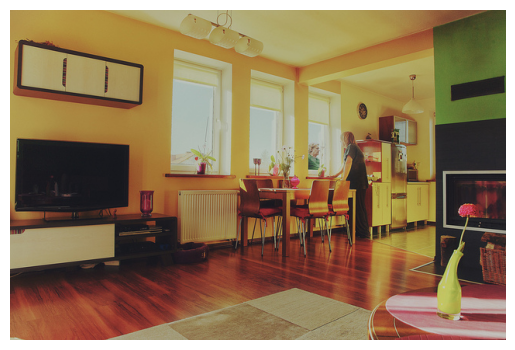

A woman stands in the dining area at the table.
A room with chairs, a table, and a woman in it.
A woman standing in a kitchen by a window
A person standing at a table in a room.
A living area with a television and a table


In [ ]:
image_id = '000000000139.jpg'
# Visualize the img and its captions
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(val_dataset.img_dir / image_id).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

cocoval = json.load(open('./data/captions_val2017.json'))
for ann in cocoval['annotations']:
    if ann['image_id'] == 139:
        print(ann['caption'])

In [ ]:
emb = val_dataset.embedding_map['000000000139.jpg']
vec2text_model.predict(emb, target_lang='eng_Latn')

['A living area with a television and a table',
 'A person standing at a table in a room.',
 'A room with chairs, a table, and a woman in it.',
 'A woman standing in a kitchen by a window',
 'A woman stands in the dining area at the table.']

In [ ]:
# vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
#                                               tokenizer="text_sonar_basic_encoder",
#                                               device=torch.device(device),
#                                               dtype=torch.float16)
pred_emb = encoder(img.unsqueeze(0).to(device))      # => (1, D) float32 or float16
pred_emb = pred_emb.to(torch.float32).cpu()          # back to float32 on CPU
print(f"Predicted embed type is {pred_emb.dtype}")
vec2text_model.predict(pred_emb.to(torch.float16), target_lang='eng_Latn')

Predicted embed type is torch.float32


['kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitchen kitche

### Resnet152 Encoder

In [ ]:
class ResNet152Embedder(nn.Module):
    """
    ResNet50 backbone producing fixed-size embeddings (e.g., 1024-D).

    Args:
        pretrained (bool): If True, loads ImageNet-pretrained weights.
        embedding_dim (int): Dimensionality of the output embedding.
    """
    def __init__(self, pretrained: bool = True, embedding_dim: int = 1024):
        super().__init__()
        # Load ResNet50 backbone
        weights = ResNet152_Weights.DEFAULT if pretrained else None
        base_model = resnet152(weights=weights)
        # Save the feature dimensionality for projection
        in_features = base_model.fc.in_features
        # Replace the final fully connected layer with a new one
        base_model.fc = nn.Linear(in_features, embedding_dim)
        # Initialize the new layer
        nn.init.xavier_uniform_(base_model.fc.weight)
        self.backbone = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: image -> embedding

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Embedding of shape (batch_size, embedding_dim).
        """
        embeddings = self.backbone(x)   # shape: (batch_size, embedding_dim)
        return embeddings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example: produce 1024-D embeddings
model = ResNet152Embedder(pretrained=True, embedding_dim=1024).to(device)
summary(model, (3, 224, 224), device=device.type)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
embed = model(dummy_input)
print(f"Output embedding shape: {embed.shape}")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /Users/miaoyidi/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 54.1MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,